In [1]:
import pandas as pd

true_df = pd.read_csv('True.csv') #21417개
fake_df = pd.read_csv('Fake.csv') #23481개

In [2]:
#결측값 제거함수
fake_df = fake_df.dropna(subset=['date'])
true_df = true_df.dropna(subset=['date'])

true_df['label'] = 1
fake_df['label'] = 0
#true_df에 맞게 데이터 개수 조절하여 데이터 불균형 해소
filtered_fake_df = fake_df.sample(n = 21417, random_state=42)
#데이터 결합
totalnews_df = pd.concat([true_df, filtered_fake_df]).reset_index(drop=True)


In [3]:
#결측값 확인 함수 --> 현재 데이터셋은 결측값 X
print(totalnews_df.isnull().sum())

title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [4]:
# 최종 수정 코드
import pandas as pd
import re
import contractions
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

# 전처리 함수 (모든 오류 수정 버전)
def process_text(text):
    # 1. HTML 태그 제거
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # 2. 축약어 확장 (contractions 미설치 시 expand_contractions() 사용)
    text = contractions.fix(text)
    
    # 3. 특수 문자 제거
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # ASCII 외 문자 제거
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # 알파벳, 숫자, 공백만 남김
    
    # 4. 공백 정리
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 5. 소문자 변환
    text = text.lower()
    
    # 6. 토큰화 + 불용어 제거
    tokens = word_tokenize(text)
    stopword_set = set(stopwords.words('english'))  # 변수명 수정!
    tokens = [word for word in tokens if word not in stopword_set and len(word) > 2]
    
    # 7. 표제어 추출
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# 2. title과 text 모두 전처리 후 합치는 방식 채택
tqdm.pandas(desc="텍스트 전처리 진행 중")
totalnews_df['cleaned_title'] = totalnews_df['title'].progress_apply(process_text)
totalnews_df['cleaned_text'] = totalnews_df['text'].progress_apply(process_text)
totalnews_df['cleaned_title_text'] = totalnews_df['cleaned_title'] + '/' + totalnews_df['cleaned_text']

텍스트 전처리 진행 중:  54%|█████▍    | 23270/42834 [01:32<01:31, 213.68it/s]C:\Users\UserK\AppData\Local\Temp\ipykernel_23136\3121101702.py:15: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(text, "html.par

In [5]:
granular_subjects = {
    #2.새로운 주제 체계 생성
    'presidential_news' : ['trump', 'biden', 'obama', 'white house', 'oval office', 'president', 'potus'],
    'political_news' : ['prime minister', 'senate', 'congress', 'republican', 'democrat', 'government', 'agency'],
    'international_news' : ['russia', 'china', 'north korea', 'kim jong un', 'putin', 'foreign', 'iran', 'international', 'global', 'south korea'],
    'crime_news' : ['arrested', 'charged', 'murder', 'shooting', 'police', 'court', 'judge', 'investigation', 'criminal'],
    'media_news' : ['cnn', 'fox news', 'msnbc', 'reporter', 'interview', 'broadcast', 'journalist'],
    'conspiracy_theory' : ['deep state', 'soros', 'qanon', 'hoax', 'false flag', 'fake news', 'conspiracy'],
    'economy_news' : ['economy', 'stock', 'market', 'jobs', 'employment', 'gdp', 'inflation'],
    'health_news': ['vaccine', 'health', 'hospital', 'doctor', 'cdc']
}

In [6]:
#주제 재할당
def refined_granular_subjects(text, return_multiple=False):
    #주제는 모두 소문자
    text = str(text).lower()
    matched_subjects=[]
    #각 주제의 키워드들 순회
    for subject, keywords in granular_subjects.items():
        for kw in keywords:
            # 단어 단위 매칭 (정규표현식)
            if re.search(r'\b' + re.escape(kw) + r'\b', text):
                return subject
    return 'general' #모든 주제의 키워드들 체크해도 없으면 기본값 반환

In [7]:
#cleaned_title_text 컬럼을 읽으면서 subject 재정의
totalnews_df['subject'] = totalnews_df['cleaned_title_text'].apply(refined_granular_subjects)

In [8]:
# 주제별 데이터 개수 세기
subject_counts = totalnews_df['subject'].value_counts()
print(subject_counts)

subject
presidential_news     29941
political_news         6927
general                2015
crime_news             1784
international_news     1254
media_news              641
health_news             125
economy_news             97
conspiracy_theory        50
Name: count, dtype: int64


In [9]:
import nltk # 자연어 처리 라이브러리
from nltk.corpus import opinion_lexicon # (opinion_lexicon 긍정,부정 단어 제공) VADER, SentiWordNet, TextBlob가 더 정교한 감정분석
nltk.download('opinion_lexicon') # 긍정, 부정 단어 리스트 다운로드


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\UserK\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [10]:
# 긍정 및 부정 단어 리스트 로드
positive_words = set(opinion_lexicon.positive()) # 긍정 단어 집합
negative_words = set(opinion_lexicon.negative()) # 부정 단어 집합

# 텍스트에서 긍정 단어 수와 부정 단어 수를 모두 계산하여 반환
def count_sentiment_words(text):
    
    # 텍스트를 공백 단위로 분리하여 단어 리스트 생성 ex) "I am happy" -> ['I', 'am', 'happy'] 감성 사전은 단어 기준
    words = text.split()
    
    # 긍정 단어 수 계산
    positive_words_count = sum(1 for word in words if word in positive_words)
    
    # 부정 단어 수 계산
    negative_words_count = sum(1 for word in words if word in negative_words)
    
    return positive_words_count, negative_words_count


In [11]:
# 진짜 뉴스 텍스트 결합
true_news_text = ' '.join(totalnews_df[totalnews_df['label'] == 1]['cleaned_title_text'])

# 가짜 뉴스 텍스트 결합
fake_news_text = ' '.join(totalnews_df[totalnews_df['label'] == 0]['cleaned_title_text'])


In [12]:
# 진짜 뉴스 긍정/부정 단어 수 계산
true_news_positive_words_count, true_news_negative_words_count = count_sentiment_words(true_news_text)

# 가짜 뉴스 긍정/부정 단어 수 계산
fake_news_positive_words_count, fake_news_negative_words_count = count_sentiment_words(fake_news_text)

# 결과 출력
print(f"진짜 뉴스의 긍정 단어 수: {true_news_positive_words_count}, 부정 단어 수: {true_news_negative_words_count}")
print(f"가짜 뉴스의 긍정 단어 수: {fake_news_positive_words_count}, 부정 단어 수: {fake_news_negative_words_count}")


진짜 뉴스의 긍정 단어 수: 253078, 부정 단어 수: 261522
가짜 뉴스의 긍정 단어 수: 309113, 부정 단어 수: 341843


In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
import numpy as np

import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지


In [14]:
# 텍스트를 단어 단위로 분리
true_news_words = true_news_text.split()
fake_news_words = fake_news_text.split()

# 부정적인 단어만 추출
true_news_negative_words = [word for word in true_news_words if word in negative_words]
fake_news_negative_words = [word for word in fake_news_words if word in negative_words]

# 빈도수 계산
true_news_negative_frequency = Counter(true_news_negative_words)
fake_news_negative_frequency = Counter(fake_news_negative_words)

# 각 뉴스에서 상위 20개 부정 단어 추출
top20_true_news_negative_words = true_news_negative_frequency.most_common(20)
top20_fake_news_negative_words = fake_news_negative_frequency.most_common(20)

# 진짜 뉴스에서 상위 20개 부정 단어
top20_true_news_negative_words = true_news_negative_frequency.most_common(20)
print("Top 20 Negative Words in True News:")
print(top20_true_news_negative_words)

# 가짜 뉴스에서 상위 20개 부정 단어
top20_fake_news_negative_words = fake_news_negative_frequency.most_common(20)
print("\nTop 20 Negative Words in Fake News:")
print(top20_fake_news_negative_words)





Top 20 Negative Words in True News:
[('issue', 6455), ('attack', 6346), ('conservative', 4601), ('opposition', 4152), ('killed', 3794), ('concern', 3690), ('crisis', 3123), ('threat', 2694), ('protest', 2434), ('conflict', 2304), ('denied', 2261), ('allegation', 2170), ('problem', 2042), ('rival', 1970), ('vice', 1941), ('death', 1929), ('strike', 1886), ('debt', 1871), ('risk', 1837), ('failed', 1825)]

Top 20 Negative Words in Fake News:
[('attack', 6115), ('conservative', 4783), ('issue', 4274), ('racist', 3665), ('problem', 3344), ('illegal', 3151), ('death', 3075), ('fake', 3061), ('hate', 2958), ('lie', 2795), ('crime', 2757), ('threat', 2668), ('protest', 2541), ('criminal', 2531), ('bad', 2524), ('hard', 2329), ('wrong', 1988), ('killed', 1965), ('lost', 1935), ('terror', 1667)]


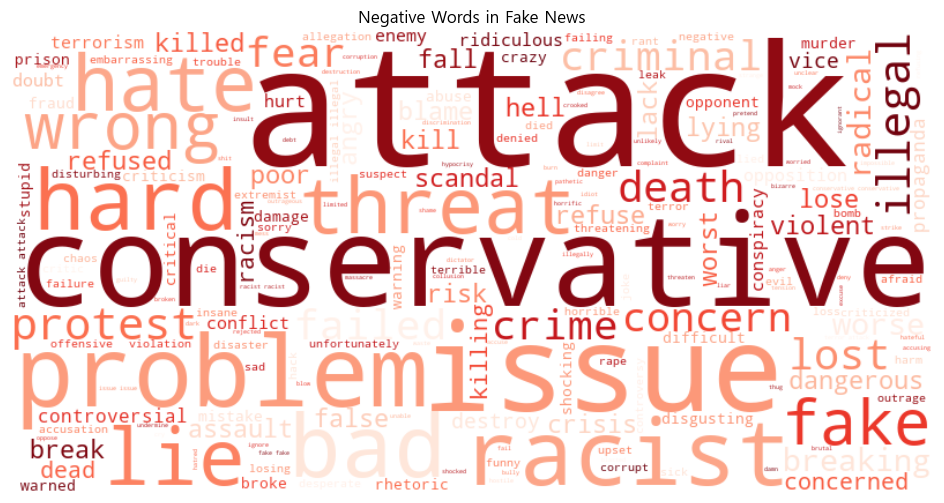

In [15]:
# 부정적인 단어 텍스트 결합
fake_news_negative_text = ' '.join(fake_news_negative_words)

# 워드클라우드 생성
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds'
).generate(fake_news_negative_text)

# 시각화
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words in Fake News')
plt.show()


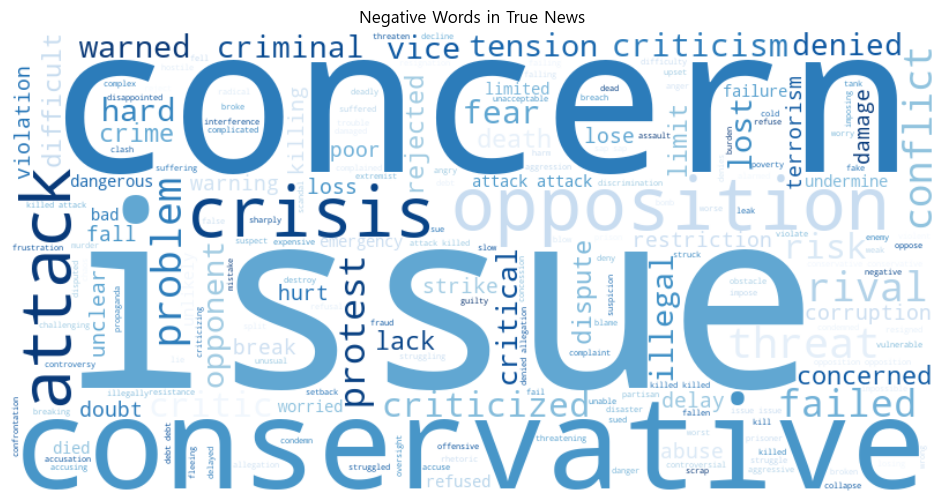

In [16]:
# 부정적인 단어 텍스트 결합
true_news_negative_text = ' '.join(true_news_negative_words)

# 워드클라우드 생성
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Blues'
).generate(true_news_negative_text)

# 시각화
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words in True News')
plt.show()


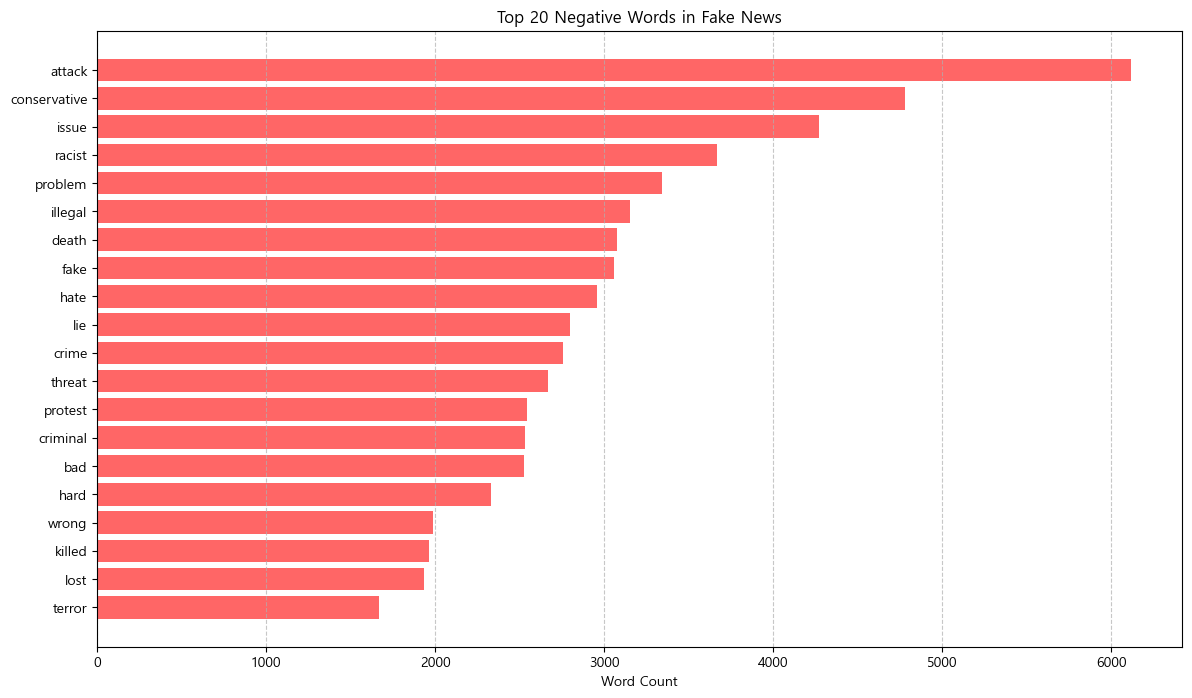

In [17]:
# 상위 단어 추출
top20_fake_news_negative_words = fake_news_negative_frequency.most_common(20)

# 단어와 빈도 리스트로 분리
if top20_fake_news_negative_words:
    words, counts = zip(*top20_fake_news_negative_words)
    words = list(words)
    counts = list(counts)
    
# 막대그래프 시각화
plt.figure(figsize=(14, 8))
plt.barh(words, counts, color='#ff6666')
plt.title('Top 20 Negative Words in Fake News')
plt.xlabel('Word Count')
plt.gca().invert_yaxis() # y축 위에서 아래로 작아지는 방향
plt.grid(axis='x', linestyle='--', alpha=0.7) # x축 점선 
plt.show()


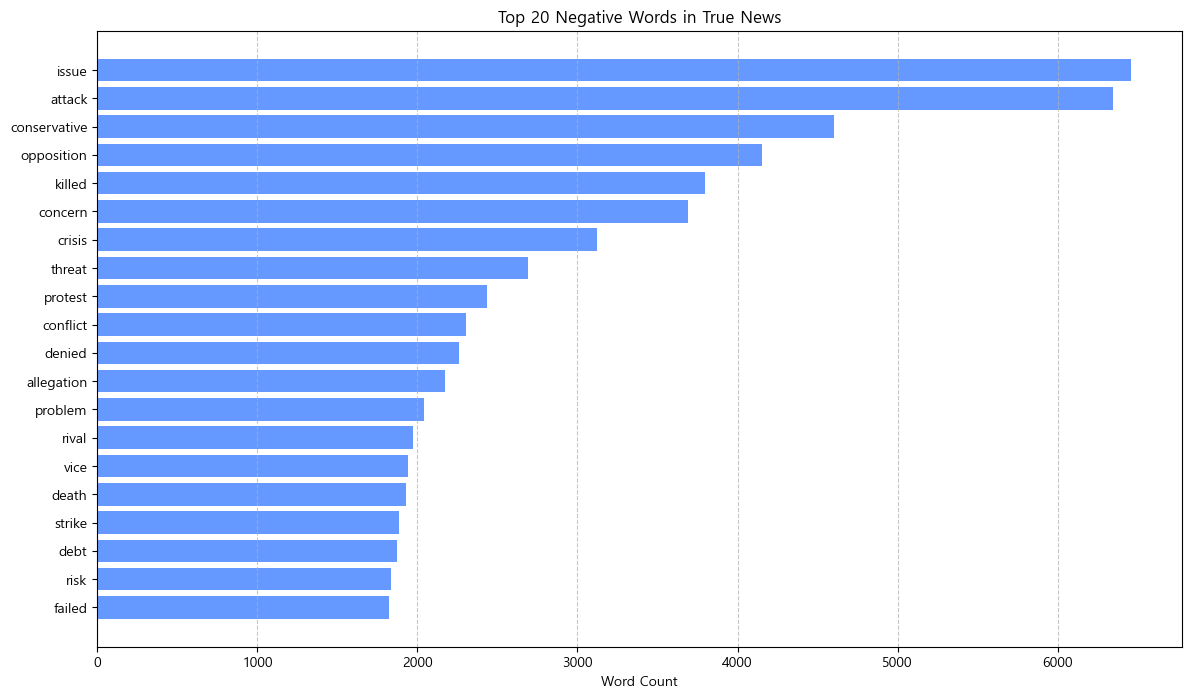

In [18]:
# 상위 단어 추출
top20_true_news_negative_words = true_news_negative_frequency.most_common(20)

# 단어와 빈도 리스트로 분리
if top20_true_news_negative_words:
    words, counts = zip(*top20_true_news_negative_words)
    words = list(words)
    counts = list(counts)
    
# 막대그래프 시각화
plt.figure(figsize=(14, 8))
plt.barh(words, counts, color='#6699ff')
plt.title('Top 20 Negative Words in True News')
plt.xlabel('Word Count')
plt.gca().invert_yaxis() # y축 위에서 아래로 작아지는 방향
plt.grid(axis='x', linestyle='--', alpha=0.7) # x축 점선 
plt.show()


In [19]:
# 키워드 리스트 'presidential_news','political_news'
keywords = [
    'trump', 'biden', 'obama', 'white house', 'oval office', 'president', 'potus',
    'prime minister', 'senate', 'congress', 'republican', 'democrat', 'government', 'agency'
]

# 빈도 계산
true_news_keywords_counts = {kw: true_news_text.count(kw) for kw in keywords}
fake_news_keywords_counts = {kw: fake_news_text.count(kw) for kw in keywords}

# 데이터프레임 정리
df_frequency = pd.DataFrame({
    'Keyword': keywords,
    'True News Count': [true_news_keywords_counts[kw] for kw in keywords],
    'Fake News Count': [fake_news_keywords_counts[kw] for kw in keywords]
})

# 결과 출력
print(df_frequency)


           Keyword  True News Count  Fake News Count
0            trump            60694            87285
1            biden              399              870
2            obama            12499            21320
3      white house             9211             6531
4      oval office              231              446
5        president            37588            32571
6            potus              128              688
7   prime minister             4267              574
8           senate            10018             3550
9         congress             9900             6069
10      republican            23998            16290
11        democrat            17014            12121
12      government            20567             9263
13          agency             6822             2993


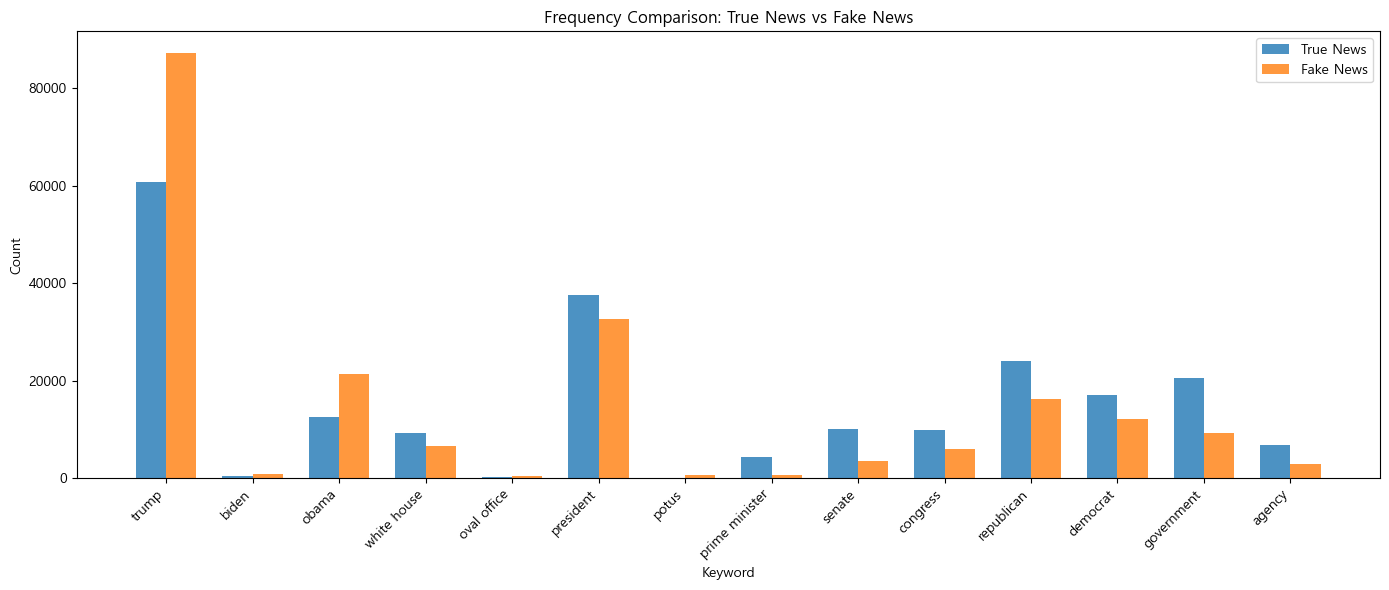

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 키워드 목록과 인덱스
keywords = df_frequency['Keyword']
x = np.arange(len(keywords))  # x축 위치
width = 0.35  # 막대 너비

# 그래프 생성
fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - width/2, df_frequency['True News Count'], width, label='True News', alpha=0.8)
rects2 = ax.bar(x + width/2, df_frequency['Fake News Count'], width, label='Fake News', alpha=0.8)

# 텍스트 및 스타일 설정
ax.set_title('Frequency Comparison: True News vs Fake News')
ax.set_xlabel('Keyword')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(keywords, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


In [21]:
# 관심 있는 키워드
person_keywords = ['trump', 'obama']

# 1. 가짜 뉴스 내 trump, obama
fake_news_person_total_keywords = sum(fake_news_keywords_counts[kw] for kw in person_keywords)

# 2. 가짜 뉴스 내 다른 정치 키워드
fake_news_total_keywords = sum(fake_news_keywords_counts[kw] for kw in keywords)

# 3. 진짜 뉴스 내 trump, obama
true_news_person_total_keywords = sum(true_news_keywords_counts[kw] for kw in person_keywords)

# 4. 진짜 뉴스 내 다른 정치 키워드
true_news_total_keywords = sum(true_news_keywords_counts[kw] for kw in keywords)

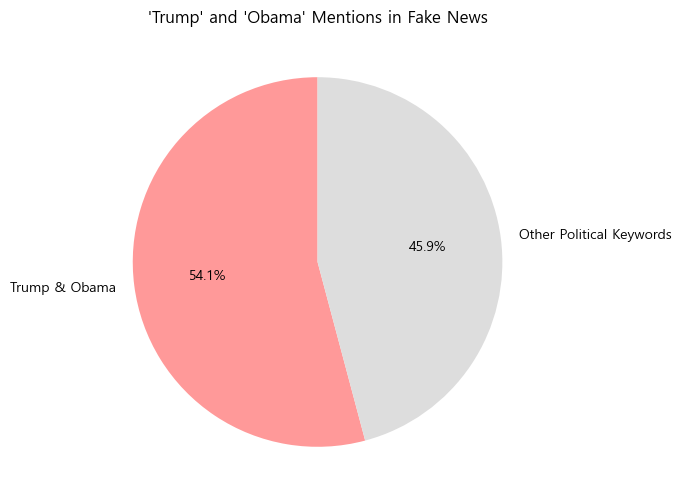

In [22]:

labels = ['Trump & Obama', 'Other Political Keywords']
sizes = [fake_news_person_total_keywords, fake_news_total_keywords - fake_news_person_total_keywords]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#dddddd'])
plt.title("'Trump' and 'Obama' Mentions in Fake News")
plt.show()


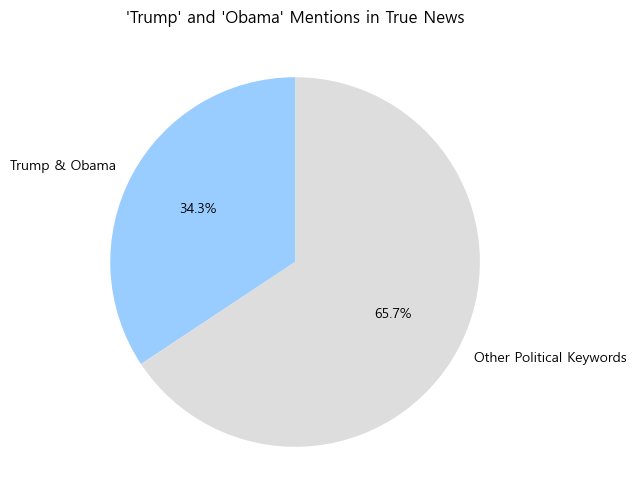

In [23]:
labels = ['Trump & Obama', 'Other Political Keywords']
sizes = [true_news_person_total_keywords, true_news_total_keywords - true_news_person_total_keywords]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#99ccff', '#dddddd'])
plt.title("'Trump' and 'Obama' Mentions in True News")
plt.show()


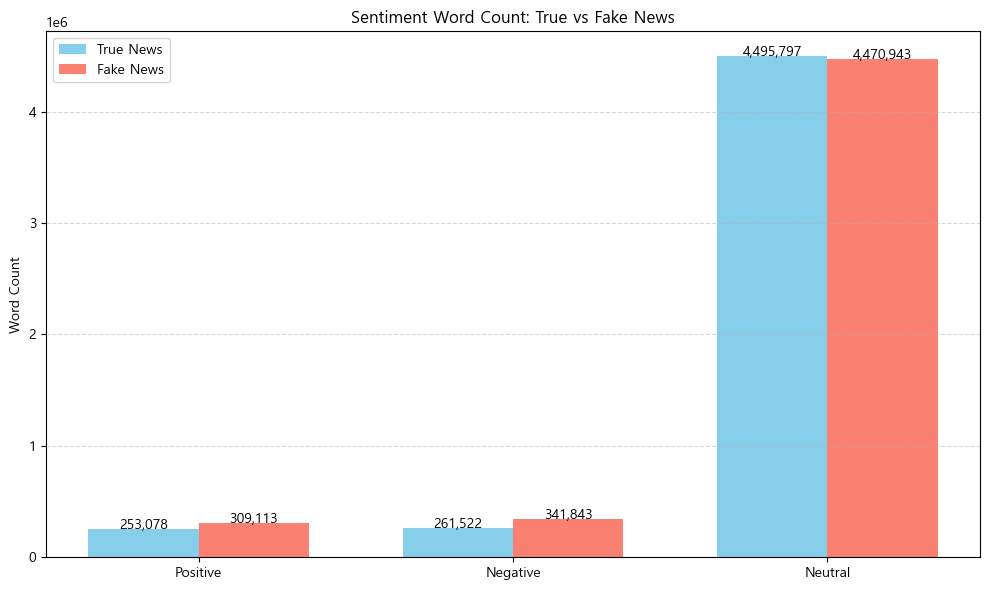

In [24]:
# 감정 단어 수 계산
def sentiment_counts(text):
    tokens = text.split()
    total = len(tokens)
    pos = sum(1 for w in tokens if w in positive_words)
    neg = sum(1 for w in tokens if w in negative_words)
    neutral = total - pos - neg
    return pos, neg, neutral

true_pos, true_neg, true_neutral = sentiment_counts(true_news_text)
fake_pos, fake_neg, fake_neutral = sentiment_counts(fake_news_text)

# 범주별 데이터
categories = ['Positive', 'Negative', 'Neutral']
true_counts = [true_pos, true_neg, true_neutral]
fake_counts = [fake_pos, fake_neg, fake_neutral]

# 그룹형 막대그래프
x = np.arange(len(categories))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, true_counts, width, label='True News', color='skyblue')
plt.bar(x + width/2, fake_counts, width, label='Fake News', color='salmon')

# 값 표시
for i in range(len(categories)):
    plt.text(x[i] - width/2, true_counts[i] + 1000, f'{true_counts[i]:,}', ha='center', fontsize=10)
    plt.text(x[i] + width/2, fake_counts[i] + 1000, f'{fake_counts[i]:,}', ha='center', fontsize=10)

plt.xticks(x, categories)
plt.ylabel('Word Count')
plt.title('Sentiment Word Count: True vs Fake News')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [25]:
from sklearn.model_selection import train_test_split

In [26]:
# 독립 변수와 종속 변수 정의
X = totalnews_df['cleaned_title_text']
y = totalnews_df['label']

In [27]:
# 80% 훈련 데이터, 20% 테스트 데이터
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("훈련 데이터 개수:", len(X_train))
print("테스트 데이터 개수:", len(X_test))

훈련 데이터 개수: 34267
테스트 데이터 개수: 8567


In [28]:
# 훈련 데이터프레임 생성
train_df = pd.DataFrame({'text': X_train, 'label': y_train})

# 테스트 데이터프레임 생성
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

print("훈련 데이터프레임 구조:")
print(train_df.head())

print("\n테스트 데이터프레임 구조:")
print(test_df.head())

훈련 데이터프레임 구조:
                                                    text  label
19020  trump say puerto rico trouble hurricane debt m...      1
25054  hollyweird lib susan sarandon compare muslim r...      0
27211  trump going kill coastline program benefit eco...      0
37027  new study show major insurer hate aca actually...      0
35394  flashback chicago resident blast chicago mayor...      0

테스트 데이터프레임 구조:
                                                    text  label
11858  least dead bus crash excursion mexican ruin/me...      1
22088  shocking audio released john kerry discussing ...      0
18960  commando storm plane philippinesyous hijack si...      1
18432  yous decide soon future taliban office qatar/w...      1
17210  youn urge bangladesh move rohingya refugee str...      1


In [29]:
#TF-IDF 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

# 3. 훈련 데이터에 대해 fit(단어 사전 학습) + transform(벡터 변환) 동시에 실행
# - X_train: 훈련용 텍스트(문장)
X_train_tfidf = vectorizer.fit_transform(X_train)

# 4. 테스트 데이터는 transform만 실행 (fit은 절대 사용하지 않음!)
# - X_test: 테스트용 텍스트(문장)
X_test_tfidf = vectorizer.transform(X_test)

#5. 벡터화 결과(희소행렬)의 크기 확인
print("훈련 데이터 벡터 차원:", X_train_tfidf.shape)  # (훈련 샘플 수, 단어 수)
print("테스트 데이터 벡터 차원:", X_test_tfidf.shape)

# 6. (선택) 단어 사전 일부 확인
print("단어 사전 예시:", vectorizer.get_feature_names_out()[:20])

훈련 데이터 벡터 차원: (34267, 190711)
테스트 데이터 벡터 차원: (8567, 190711)
단어 사전 예시: ['000' '0000' '000000017' '000004' '000048' '000063sz' '00009' '0001'
 '00011' '00018' '000270ks' '0005' '0006' '00075' '00076' '0009'
 '000938sz' '000dillon000' '001' '0019']


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 사용할 모델들 딕셔너리로 정의
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1
    })

# 결과를 표로 출력
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.988211   0.985618  0.990905  0.988254
1        Random Forest  0.985059   0.982823  0.987407  0.985109
2                  SVM  0.993347   0.991177  0.995569  0.993368
3          Naive Bayes  0.939185   0.922026  0.959655  0.940464
4        Decision Tree  0.995214   0.995335  0.995103  0.995219


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
import pandas as pd

# 사용할 모델들 딕셔너리로 정의 (7개 모델)
models = {
    # 기본 모델
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_jobs=-1, random_state=42),
    'SVM': SVC(random_state=42),
    'Naive Bayes': MultinomialNB(),
    
    # 추가 모델
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(512,), max_iter=500, random_state=42)
}

# 교차 검증 설정
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv = 1  # 데이터 크기에 따라 3으로 줄일 수 있음

# 결과 저장 리스트
results = []

for name, model in models.items():
    # 교차 검증 수행 (n_jobs=-1: 모든 CPU 코어 사용)
    cv_results = cross_validate(
        model,
        X_train_tfidf,  # BERT 사용 시 X_train_bert로 변경
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1 if name != 'MLP' else None  # MLP는 병렬처리 지원 안 함
    )
    
    # 평균값 계산
    avg_scores = {
        'Model': name,
        'Accuracy': cv_results['test_accuracy'].mean(),
        'Precision': cv_results['test_precision'].mean(),
        'Recall': cv_results['test_recall'].mean(),
        'F1-score': cv_results['test_f1'].mean(),
        'Fit Time': cv_results['fit_time'].mean()  # 학습 시간 추가
    }
    results.append(avg_scores)

# 결과 표로 정렬
results_df = pd.DataFrame(results)
print("=== 최종 모델 성능 비교 (2-fold CV) ===")
print(results_df.sort_values('F1-score', ascending=False))


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
import sys
print(sys.version)

3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
